# Visualization of the BixiBike data:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple

## Extracting the data (one month)

In [3]:
#read the csv data, using the latest month for example
month_data = pd.read_csv('BixiMontrealRentals2019\OD_2019-09.csv', sep=',')
stations = pd.read_csv('BixiMontrealRentals2019\Stations_2019.csv', sep=',').set_index('Code')

month_data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2019-09-01 00:00:04,6205,2019-09-01 00:08:15,6248,490,1
1,2019-09-01 00:00:08,6110,2019-09-01 00:03:51,6120,223,1
2,2019-09-01 00:00:09,6202,2019-09-01 00:20:24,6143,1214,0
3,2019-09-01 00:00:10,6196,2019-09-01 00:13:26,6040,795,1
4,2019-09-01 00:00:12,6014,2019-09-01 00:08:45,6132,512,1


In [4]:
stations.head()

,name,latitude,longitude
Code,,,
10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651
4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874
4001,Graham / Brookfield,45.520075,-73.629776
4002,Graham / Wicksteed,45.516937,-73.640483
5002,St-Charles / Montarville,45.533682,-73.515261


In [5]:
#check data types
month_data.dtypes

start_date            object
start_station_code     int64
end_date              object
end_station_code       int64
duration_sec           int64
is_member              int64
dtype: object

In [6]:
stations.dtypes

name          object
latitude     float64
longitude    float64
dtype: object

In [7]:
#convert dates to pandas datetime objects
month_data.start_date = pd.to_datetime(month_data.start_date)
month_data.end_date = pd.to_datetime(month_data.end_date)
month_data.dtypes

start_date            datetime64[ns]
start_station_code             int64
end_date              datetime64[ns]
end_station_code               int64
duration_sec                   int64
is_member                      int64
dtype: object

In [8]:
#merge the bike data and station tables into one
data = month_data.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_index=True)
data = data.merge(stations[['latitude','longitude']], how='left', left_on=['end_station_code'], right_index=True, suffixes=('_start','_end'))
data['start_day'] = data.start_date.apply(lambda x: x.day)
data['end_day'] = data.end_date.apply(lambda x: x.day)
data['start_hour'] = data.start_date.apply(lambda x: x.hour)
data['end_hour'] = data.end_date.apply(lambda x: x.hour)
data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,start_day,end_day,start_hour,end_hour
0,2019-09-01 00:00:04,6205,2019-09-01 00:08:15,6248,490,1,45.509361,-73.573864,45.518593,-73.581566,1,1,0,0
1,2019-09-01 00:00:08,6110,2019-09-01 00:03:51,6120,223,1,45.529033,-73.546348,45.533661,-73.552197,1,1,0,0
2,2019-09-01 00:00:09,6202,2019-09-01 00:20:24,6143,1214,0,45.510072,-73.570752,45.526890,-73.572640,1,1,0,0
3,2019-09-01 00:00:10,6196,2019-09-01 00:13:26,6040,795,1,45.521342,-73.589419,45.502786,-73.559134,1,1,0,0
4,2019-09-01 00:00:12,6014,2019-09-01 00:08:45,6132,512,1,45.512871,-73.558466,45.529135,-73.559234,1,1,0,0


## Checking Basic statistics

In [9]:
#average proximity of station rides

#haversine function calculates the distance between two coordinates (lat, lon) - can install through 'pip install haversine'
#outputs distance in km
data['distance'] = data.apply(lambda x: haversine((x.latitude_start,x.longitude_start),(x.latitude_end,x.longitude_end)),axis=1)
data.head()

NameError: ("name 'haversine' is not defined", 'occurred at index 0')

In [ ]:
#check for NaN values
#pd.isnull(data).sum()
pd.isna(data).sum()

In [ ]:
#duration vs proximity

#initial visualization of data
dd = plt.figure()
plt.scatter(data.distance, data.duration_sec)
plt.show()

In [ ]:
sns.jointplot(data.distance, data.duration_sec, kind='hex', color="#4CB391")
plt.show()

In [ ]:
#can see there is a large portion in the lower range of distance and duration (i.e. short travel)
#look closer at this subset
reduced = data.query('distance<3 & duration_sec<1000')
sns.jointplot(reduced.distance, reduced.duration_sec, kind="hex", color="#4CB391")
plt.show()

In [ ]:
#appears to be logarithmic, so try log of each
in_met = data.copy()
in_met['distance'] = in_met['distance'].apply(lambda x: x*1000)
in_met = in_met.query('distance>1')
sns.jointplot(np.log(in_met.distance.astype(int)), np.log(in_met.duration_sec), kind="hex", color="#4CB391")
plt.show()

!!Note: this does not include the zero distance (i.e. return to the same station) events!!

In [ ]:
#number of rides starting and ending at different stations
stat_count = data.groupby('start_station_code').size().to_frame()
stat_count_end = data.groupby('end_station_code').size().to_frame()
stat_count = stat_count.merge(stat_count_end, how='left', left_index=True, right_index=True)
stat_count.columns = ['trip_starts','trip_ends']
stat_count.index.names = ['station']
stat_count = stat_count.sort_values(by='trip_starts',ascending=False)

#monthly data for the stations
month_stat = stations.merge(stat_count, how='left', left_index=True, right_index=True)

month_stat.head()

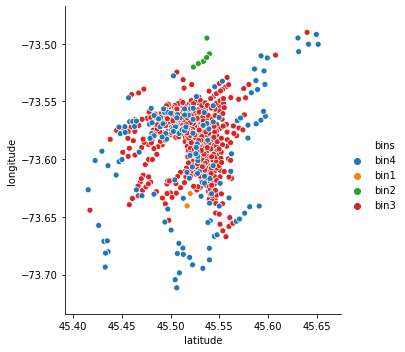

In [262]:
#plot the distribution based on the coordinates (not on map but just to see if clusters exist)
def color_code(x):
    x = int(x)
    if x<5000:
        r = 'bin1'
    elif x<6000:
        r = 'bin2'
    elif x<7000:
        r = 'bin3'
    else:
        r = 'bin4'
    return r

#color code based on code numbers (correlated to location?)
stat_col = stations.reset_index()
stat_col['bins'] = stat_col.apply(lambda x: color_code(x.Code), axis=1)
sns.relplot(x='latitude', y='longitude', hue='bins', data=stat_col)


=>Appears to be no correlation between station code and location

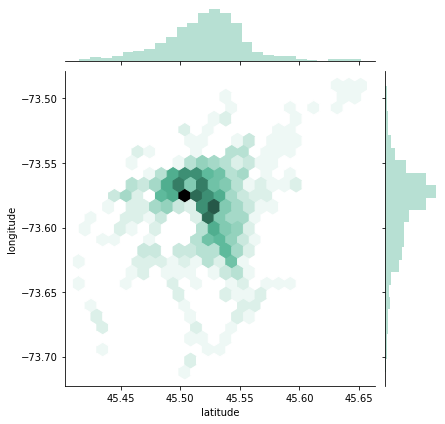

In [277]:
#density of stations across montreal
sns.jointplot(stations.latitude, stations.longitude, kind="hex", color="#4CB391")

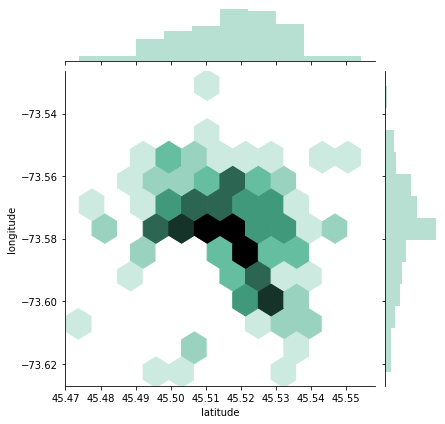

In [281]:
#visualize the station data - popularity of different areas
#shows number of stations in an area which are above a certain use threshold

reduce = month_stat.query('trip_starts>2000')
sns.jointplot(reduce.latitude, reduce.longitude, kind="hex", color="#4CB391")
plt.show()

#**** not a valid approach, need to normalize for the number of stations in that bin*****

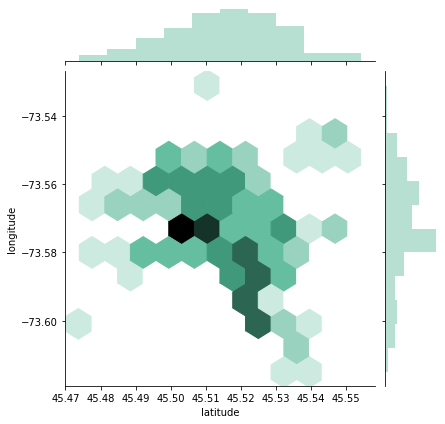

In [280]:
#same visualization for ending stations
reduce = month_stat.query('trip_ends>2000')
sns.jointplot(reduce.latitude, reduce.longitude, kind="hex", color="#4CB391")
plt.show()

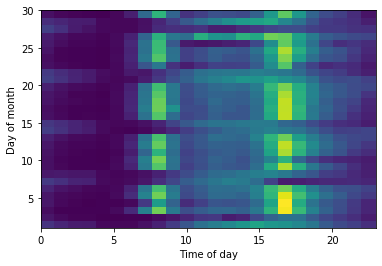

In [406]:
#time of day of usage (start of usage) vs days of the year (with overall histograms on the side)
plt.hist2d(data.start_hour, data.start_day, bins=[24,30])
plt.xlabel('Time of day')
plt.ylabel('Day of month')
plt.show()

Since we saw that the majority of trips are less than an hour, we expect the distribution for start and end times to be similar

Can observe the increased use at rush hour on week days (usage for commutes)

## Visualizing on a map

Due to the high density of stations in the core, a subset of the data in a small section of the city is used for visualization

Use heatmap to see most popular areas:

In [ ]:
#Heatmap() function on trips_start

Looking at a single station on a single day and mapping where the trips go from there:

In [380]:
#vis = month_stat.query('latitude>45.48 & latitude<45.51 & longitude<-73.56 & longitude>-73.59')
vis = data.query('start_station_code==6090 & start_day==1') #can look at different stations and days by changing this line
montreal = [45.5017, -73.5673]
start_station = vis.loc[693,['latitude_start','longitude_start']]

num_trips = vis.groupby('end_station_code').size().to_frame()
num_trips.columns = ['count']

vis = vis[['end_station_code','latitude_end','longitude_end']].merge(num_trips, how='right', left_on='end_station_code', right_index=True)
vis.head()

,end_station_code,latitude_end,longitude_end,count
693,6085,45.495200,-73.563280,1
2395,6086,45.490452,-73.560172,1
3911,6052,45.497515,-73.552571,2
3914,6052,45.497515,-73.552571,2
4043,6041,45.501441,-73.560144,2


In [381]:
#visualize stations on a map
m = folium.Map(location=montreal, zoom_start=14)
m.add_child(folium.Marker(location=start_station), name='start') #693 is index of first row
for lat, lng, name in zip(vis.latitude_end,vis.longitude_end,vis.end_station_code):
    m.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=2, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop    
m

In [397]:
#plot lines between the stations according to number of trips taken
for index, row in vis.iterrows():
    folium.PolyLine([start_station,[row.latitude_end,row.longitude_end]], color="green", weight=2*row['count']).add_to(m)
m

Trying with AntPath:

In [420]:
m_ant = folium.Map(location=montreal, zoom_start=14)
m_ant.add_child(folium.Marker(location=start_station), name='start') #693 is index of first row
for lat, lng, name in zip(vis.latitude_end,vis.longitude_end,vis.end_station_code):
    m_ant.add_child(folium.CircleMarker(location=[lat,lng], fill='true', radius=2, popup=name, fill_color='red', color='red')) #CircleMarker gives dot, Marker gives drop    

#add the paths    
for index, row in vis.iterrows():
    m_ant.add_child(folium.plugins.AntPath([start_station,[row.latitude_end,row.longitude_end]], delay=700))
    
m_ant

Code from https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e for drawing arrows:

In [412]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='black', size=6, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

#to draw the arrows calling the above 2 functions...
for index, row in vis.iterrows():
    arrows = get_arrows(locations=[start_station,[row.latitude_end,row.longitude_end]], n_arrows=1)
    for arrow in arrows:
        arrow.add_to(m)
m